# US Industrial Production
Industrial production consists of manufacturing of durable and non-durable (e.g. food, textile, etc.) goods, mining (mining, quarrying, and oil and gas extraction), and production of utilities (electricity and natural gas). Different countries have a different share of industrial production in their GDP, with developed economies tending to have a smaller portion of industrial production in their GDP. In the US industrial production makes up about 14.1% of the GDP. Its share in the US GDP has been steadily declining, mostly due to shrinkage of the manufacturing industry, whose share in the GDP shrank by -5% since 1996 and is at 10.9% now.

Since industrial production is measured based on an index chained to a particular year, it communicates _real_ changes in production.

In this notebook I analyze overall trends in US Industrial production, including trends for individual industry groups.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.ticker as mtick
import pandas_datareader.data as web
from datetime import date

In [2]:
report_start = date.fromisoformat('1959-01-01')
report_end = date.today()

In [3]:
INDPRO_SICS_COLUMN_NAME = 'Manufacturing'
INDPRO_MINE_COLUMN_NAME = 'Mining'
INDPRO_UTIL_COLUMN_NAME = 'Utilities'

## Share of Industrial production in US GDP
I calculate a share of major industry groups by looking at their value added to GDP.

In [4]:
indpro_gdp_share = web.get_data_fred(['VAPGDPMA', 'VAPGDPM', 'VAPGDPU'], start=report_start, end=report_end) / 100.
indpro_gdp_share['Total'] = indpro_gdp_share.sum(axis=1)
indpro_gdp_share = indpro_gdp_share.rename(
    columns={'VAPGDPMA': INDPRO_SICS_COLUMN_NAME,
             'VAPGDPM': INDPRO_MINE_COLUMN_NAME, 'VAPGDPU': INDPRO_UTIL_COLUMN_NAME})
indpro_gdp_share = indpro_gdp_share.iloc[:, [-1, 0, 1, 2]]

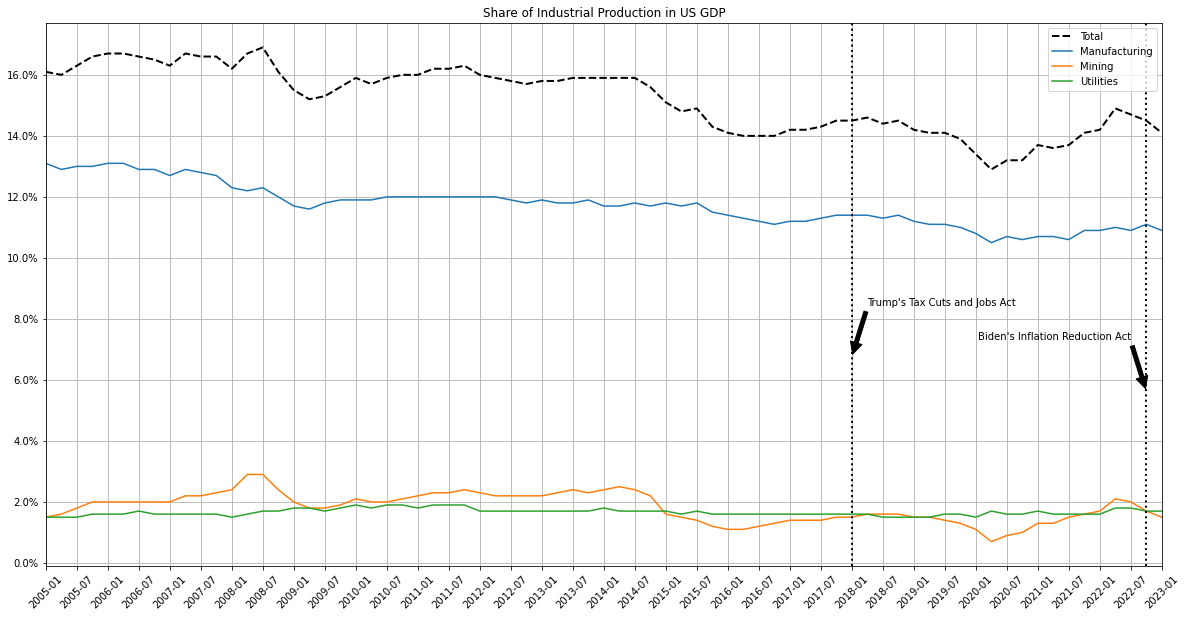

In [5]:
GRAPH_TITLE_INDPRO_GDP_SHARE = 'Share of Industrial Production in US GDP'
TAX_CUTS_DATE = '2018-1-1'
IRA_DATE = '2022-10-1' # Signed into law on August 16, 2022.
ax = indpro_gdp_share.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_GDP_SHARE,
             xticks=indpro_gdp_share.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_gdp_share.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_gdp_share.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
x1 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE)]
y1 = indpro_gdp_share.iloc[:,0].max() / 2.5
x2 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(TAX_CUTS_DATE) + 1]
y2 = y1 + indpro_gdp_share.iloc[:,0].max() / 10
ax.axvline(x1, color='k', linestyle=':', linewidth=2)

x3 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(IRA_DATE)]
x4 = indpro_gdp_share.index[indpro_gdp_share.index.get_loc(IRA_DATE) - 1]
y3 = indpro_gdp_share.iloc[:,0].max() / 3
y4 = y3 + indpro_gdp_share.iloc[:,0].max() / 10
ax.axvline(x3, color='k', linestyle=':', linewidth=2)

ax.annotate('Trump\'s Tax Cuts and Jobs Act',
            xy=(x1, y1), xytext=(x2, y2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Biden\'s Inflation Reduction Act',
            xy=(x3, y3), xytext=(x4, y4),
            arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')
ax.legend(loc='upper right')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_gdp_share.index[::2])))

### High-level Composition of US Industrial Production

In [6]:
indpro_components = web.get_data_fred(['INDPRO', 'IPMANSICS', 'IPMINE', 'IPUTIL'], start=report_start, end=report_end)

In [7]:
GRAPH_TITLE_INDPRO_COMPOSITION = 'High-level Composition of US Industrial Poduction'
LEFT_Y_AXIS_LABEL = 'Sum of individual industrial production indicies'
indpro_components_stacked = indpro_components.rename(
    columns={'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME})

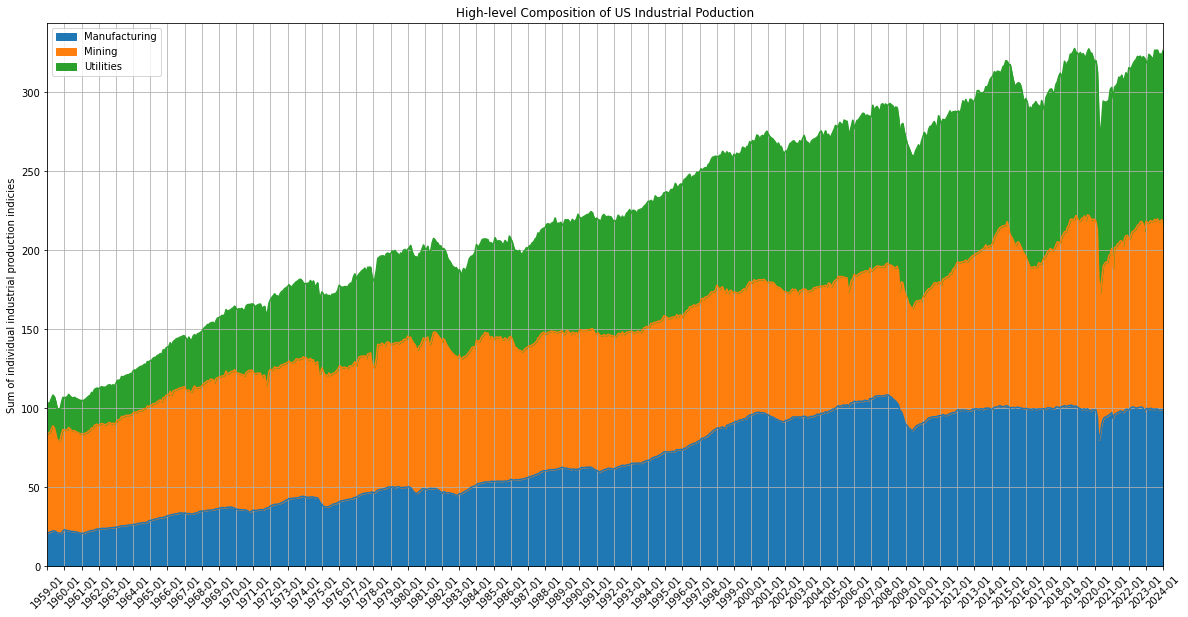

In [8]:
ax = indpro_components_stacked.iloc[:, 1:].plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                          xticks=indpro_components_stacked.index[::12], xlabel='', rot=45,
                                                    ylabel=LEFT_Y_AXIS_LABEL)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked.index[::12])))

In [9]:
# Converting to percentages by dividing by total
indpro_components_stacked_pct = indpro_components_stacked.iloc[:,1:].divide(
    indpro_components_stacked.iloc[:,1:].sum(axis=1), axis=0)

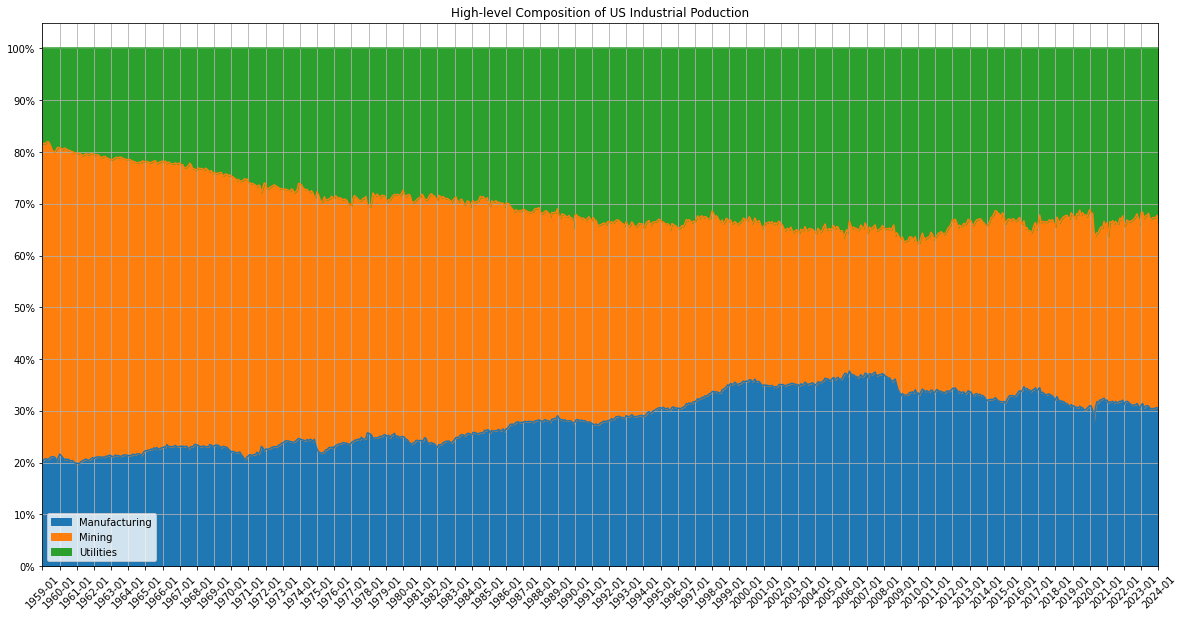

In [10]:
ax = indpro_components_stacked_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPOSITION,
                              xticks=indpro_components_stacked_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_stacked_pct.index[::12])))

### Annual Percentage Changes in Main Components of US Industrial Production

When calculating annual percentage changes I compare output in a given month with the corresponding month 12 months earlier. Some economists, when calculating annual percentage changes in industrial production in a given year, find it more accurate to look at the total production in a given year. If you wish to use this approach, please use  `indpro_components_over_12_months` instead of `indpro_components`.

In [11]:
INDPRO_COLUMN_NAME = 'Industrial Production Annual Percentage Change'
INDPRO_SICS_COLUMN_NAME = 'Manufacturing Annual Percentage Change'
INDPRO_MINE_COLUMN_NAME = 'Mining Annual Percentage Change'
INDPRO_UTIL_COLUMN_NAME = 'Utilities Annual Percentage Change'
GRAPH_TITLE_INDPRO_COMPONENTS = 'Annual Percentage Changes in Main Components of US Industrial Production'
indpro_components.rename(
    columns={'INDPRO': INDPRO_COLUMN_NAME, 'IPMANSICS': INDPRO_SICS_COLUMN_NAME,
             'IPMINE': INDPRO_MINE_COLUMN_NAME, 'IPUTIL': INDPRO_UTIL_COLUMN_NAME},
    inplace=True)

In [12]:
# When calculating annual parcentage changes over industrial production in the whole year,
# I need to filter out years that are not yet complete
mask = indpro_components.iloc[:,0].groupby(indpro_components.index.year).count() == 12
full_years = mask.index[mask == True]
indpro_components_over_12_months = indpro_components.loc[
    indpro_components.index.year.isin(mask.index[mask == True])].resample('AS-JAN').sum().pct_change().dropna()

# Converting to annual percentage changes (changes from the corresponding month a year ago)
indpro_components.update(indpro_components.pct_change(12))
indpro_components = indpro_components.loc['2003':]

In [13]:
pd.options.display.float_format = '{:.4%}'.format
pd.options.display.max_rows = 20
indpro_components.loc['2020-01':]

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
2020-01-01,-1.9311%,-1.7694%,0.6832%,-5.0650%
2020-02-01,-1.1633%,-1.1030%,0.8666%,-3.0369%
2020-03-01,-5.0194%,-5.3894%,0.1466%,-6.7821%
2020-04-01,-17.2621%,-19.5397%,-14.8826%,-2.4608%
2020-05-01,-16.0575%,-16.0556%,-25.9864%,-5.4831%
...,...,...,...,...
2023-09-01,-0.3078%,-1.1519%,2.7030%,1.7008%
2023-10-01,-1.0049%,-2.0812%,1.7759%,3.2412%
2023-11-01,-0.3878%,-0.9530%,2.1281%,0.2122%


#### Growth of total production in the whole calendar year

In [14]:
indpro_components_over_12_months

,Industrial Production Annual Percentage Change,Manufacturing Annual Percentage Change,Mining Annual Percentage Change,Utilities Annual Percentage Change
DATE,,,,
1960-01-01,2.2582%,2.1926%,1.7289%,6.9704%
1961-01-01,0.6653%,0.3383%,0.7553%,5.6057%
1962-01-01,8.3341%,8.7844%,2.8559%,7.5692%
1963-01-01,6.1279%,6.2513%,4.1215%,6.8941%
1964-01-01,6.7322%,6.8665%,4.1083%,8.5576%
...,...,...,...,...
2019-01-01,-0.6987%,-1.9712%,6.5662%,-0.8157%
2020-01-01,-7.1865%,-6.5756%,-14.8226%,-2.8953%
2021-01-01,4.3934%,4.9542%,3.1505%,1.9949%


### Zooming in on the current decade

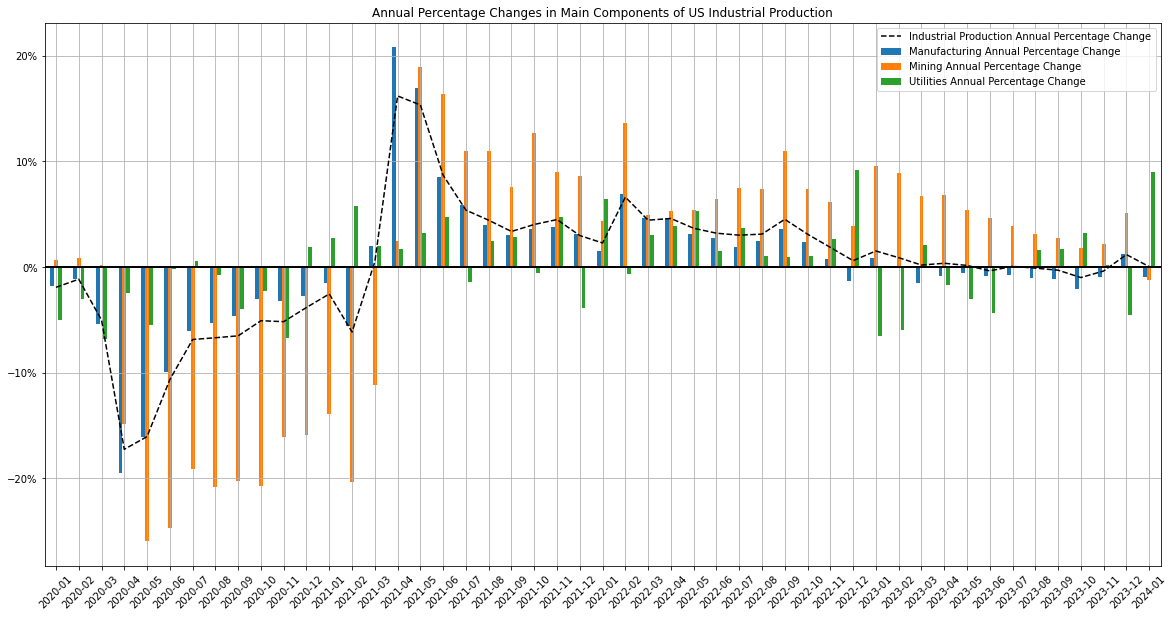

In [15]:
dt_from = date(2020, 1, 1)
indpro_components_recent = indpro_components.loc[dt_from:]
ax = indpro_components_recent.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_INDPRO_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
indpro_components_recent.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_components_recent.index)))

### Capacity Utilization of Main Components of US Industrial Production

In [16]:
indpro_utilization = web.get_data_fred(['TCU', 'CUMFNS', 'CAPUTLG21S', 'CAPUTLG2211A2S'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indpro_utilization = indpro_utilization.loc[dt_from:]

In [17]:
INDPRO_TOTAL_CU_COLUMN_NAME = 'Total Capacity Utilization'
INDPRO_SICS_CU_COLUMN_NAME = 'Manufacturing Capacity Utilization'
INDPRO_MINE_CU_COLUMN_NAME = 'Mining Capacity Utilization'
INDPRO_UTIL_CU_COLUMN_NAME = 'Utilities Capacity Utilization'
GRAPH_TITLE_INDPRO_CU = 'US Industrial Production Capacity Utilization'
indpro_utilization.rename(
    columns={'TCU': INDPRO_TOTAL_CU_COLUMN_NAME, 'CUMFNS': INDPRO_SICS_CU_COLUMN_NAME,
             'CAPUTLG21S': INDPRO_MINE_CU_COLUMN_NAME, 'CAPUTLG2211A2S': INDPRO_UTIL_CU_COLUMN_NAME},
    inplace=True)

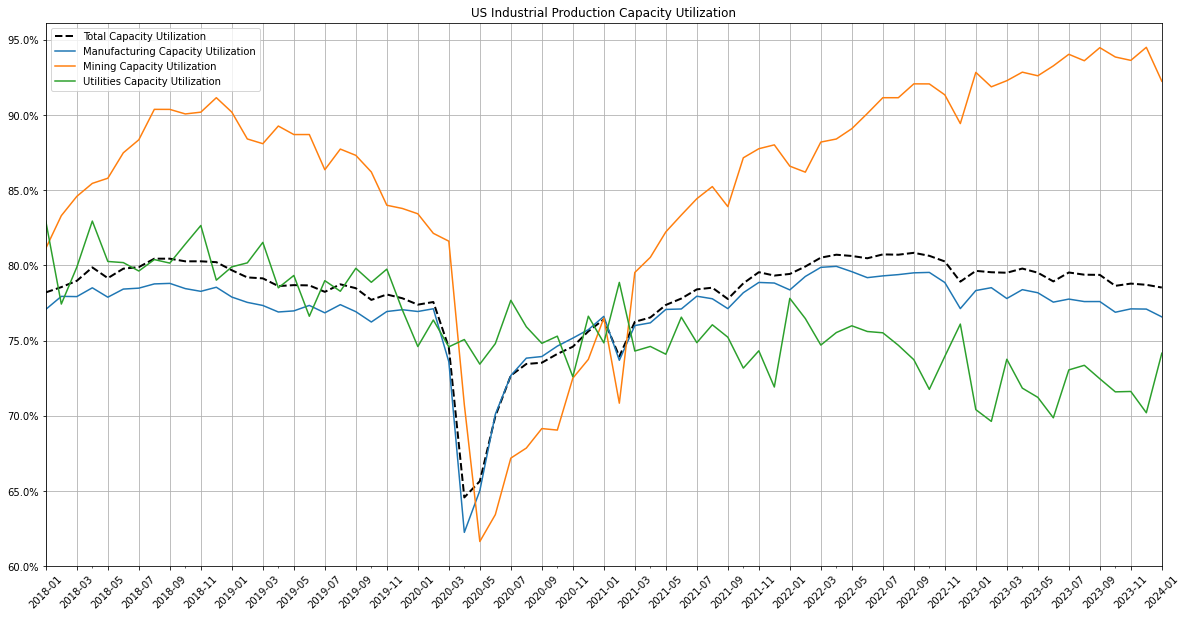

In [18]:
ax = indpro_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDPRO_CU,
             xticks=indpro_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indpro_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indpro_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indpro_utilization.index[::2])))

In [19]:
indpro_utilization

,Total Capacity Utilization,Manufacturing Capacity Utilization,Mining Capacity Utilization,Utilities Capacity Utilization
DATE,,,,
2018-01-01,78.2060%,77.0771%,81.1347%,82.9323%
2018-02-01,78.5556%,77.9413%,83.3083%,77.4301%
2018-03-01,78.9760%,77.9263%,84.5911%,79.8849%
2018-04-01,79.8677%,78.5110%,85.4544%,82.9495%
2018-05-01,79.1543%,77.8856%,85.7970%,80.2620%
...,...,...,...,...
2023-09-01,79.3695%,77.5969%,94.4789%,72.4614%
2023-10-01,78.6423%,76.8862%,93.8581%,71.5919%
2023-11-01,78.7901%,77.1097%,93.6339%,71.6178%


## Zooming in on the Manufacturing Industry Group

### GDP Share of Durable and Nondurable Manufacturing industry groups

In [20]:
INDPRO_DM_COLUMN_NAME = 'Durable Manufacturing'
INDPRO_NDM_COLUMN_NAME = 'Nondurable Manufacturing'

In [21]:
manuf_gdp_share = web.get_data_fred(['VAPGDPMA', 'VAPGDPMD', 'VAPGDPMN'], start=report_start, end=report_end) / 100.
manuf_gdp_share = manuf_gdp_share.rename(
    columns={'VAPGDPMA': 'Total Manufacturing',
             'VAPGDPMD': INDPRO_DM_COLUMN_NAME, 'VAPGDPMN': INDPRO_NDM_COLUMN_NAME})

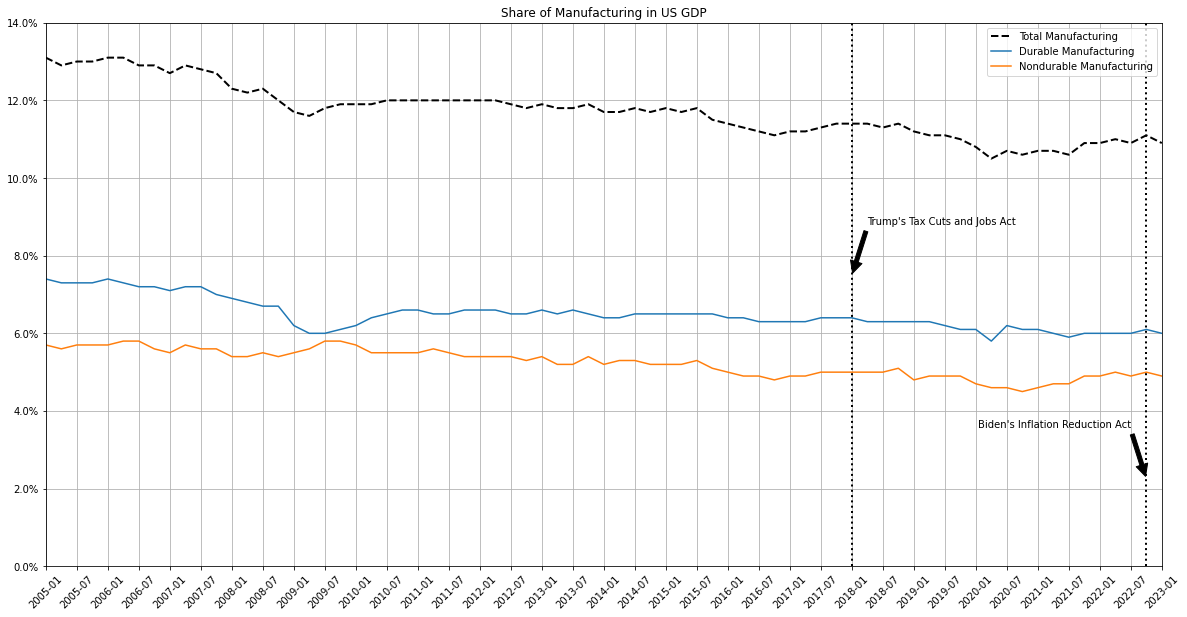

In [22]:
GRAPH_TITLE_MANUF_GDP_SHARE = 'Share of Manufacturing in US GDP'
ax = manuf_gdp_share.iloc[:,:1].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_MANUF_GDP_SHARE,
                                     xticks=manuf_gdp_share.index[::2], xlabel='', rot=45,
                                     linestyle='--', linewidth=2, color='k')
manuf_gdp_share.iloc[:,1:].plot(ax=ax, grid=True, xticks=manuf_gdp_share.index[::2], xlabel='', rot=45,
                                yticks=np.arange(0, .14, .02))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
x1 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(TAX_CUTS_DATE)]
y1 = manuf_gdp_share.iloc[:,0].max() / 1.75
x2 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(TAX_CUTS_DATE) + 1]
y2 = y1 + manuf_gdp_share.iloc[:,0].max() / 10
ax.axvline(x1, color='k', linestyle=':', linewidth=2)

x3 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(IRA_DATE)]
x4 = manuf_gdp_share.index[manuf_gdp_share.index.get_loc(IRA_DATE) - 1]
y3 = indpro_gdp_share.iloc[:,0].max() / 7.5
y4 = y3 + manuf_gdp_share.iloc[:,0].max() / 10
ax.axvline(x3, color='k', linestyle=':', linewidth=2)

ax.annotate('Trump\'s Tax Cuts and Jobs Act',
            xy=(x1, y1), xytext=(x2, y2),
            arrowprops=dict(facecolor='black', shrink=0.05))
ax.annotate('Biden\'s Inflation Reduction Act',
            xy=(x3, y3), xytext=(x4, y4),
            arrowprops=dict(facecolor='black', shrink=0.05), horizontalalignment='right')
ax.legend(loc='upper right')
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, manuf_gdp_share.index[::2])))

### Annual Percentage Changes in Components of Manufacturing Industry Group

In [23]:
ipman_components = web.get_data_fred(['IPDMAN', 'IPNMAN', 'IPGMFOS'], start=report_start, end=report_end)

# Converting to annual percentage changes (changes from the corresponding month a year ago)
ipman_components.update(ipman_components.pct_change(12))
ipman_components = ipman_components.loc['2003':]
ipman_components = pd.concat([indpro_components.iloc[:,1], ipman_components], axis=1)

In [24]:
IPDMAN_COLUMN_NAME = 'Durable Manufacturing Annual Percentage Change'
IPNMAN_COLUMN_NAME = 'Non-Durable Manufacturing Annual Percentage Change'
IPGMFOS_COLUMN_NAME = 'Other Manufacturing Annual Percentage Change'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'Annual Percentage Changes in Main Components of US Manufacturing'
ipman_components.rename(
    columns={'IPDMAN': IPDMAN_COLUMN_NAME, 'IPNMAN': IPNMAN_COLUMN_NAME,
             'IPGMFOS': IPGMFOS_COLUMN_NAME},
    inplace=True)

In [25]:
ipman_components.loc['2020-01':]

,Manufacturing Annual Percentage Change,Durable Manufacturing Annual Percentage Change,Non-Durable Manufacturing Annual Percentage Change,Other Manufacturing Annual Percentage Change
DATE,,,,
2020-01-01,-1.7694%,-2.7665%,-0.8154%,0.4281%
2020-02-01,-1.1030%,-2.0077%,-0.0993%,-1.5229%
2020-03-01,-5.3894%,-8.8837%,-1.3950%,-7.1019%
2020-04-01,-19.5397%,-27.8086%,-10.1966%,-20.5412%
2020-05-01,-16.0556%,-22.4746%,-8.7324%,-18.2717%
...,...,...,...,...
2023-09-01,-1.1519%,-0.3064%,-1.8826%,-3.9407%
2023-10-01,-2.0812%,-2.1719%,-1.9161%,-3.9119%
2023-11-01,-0.9530%,0.0052%,-1.7738%,-4.0678%


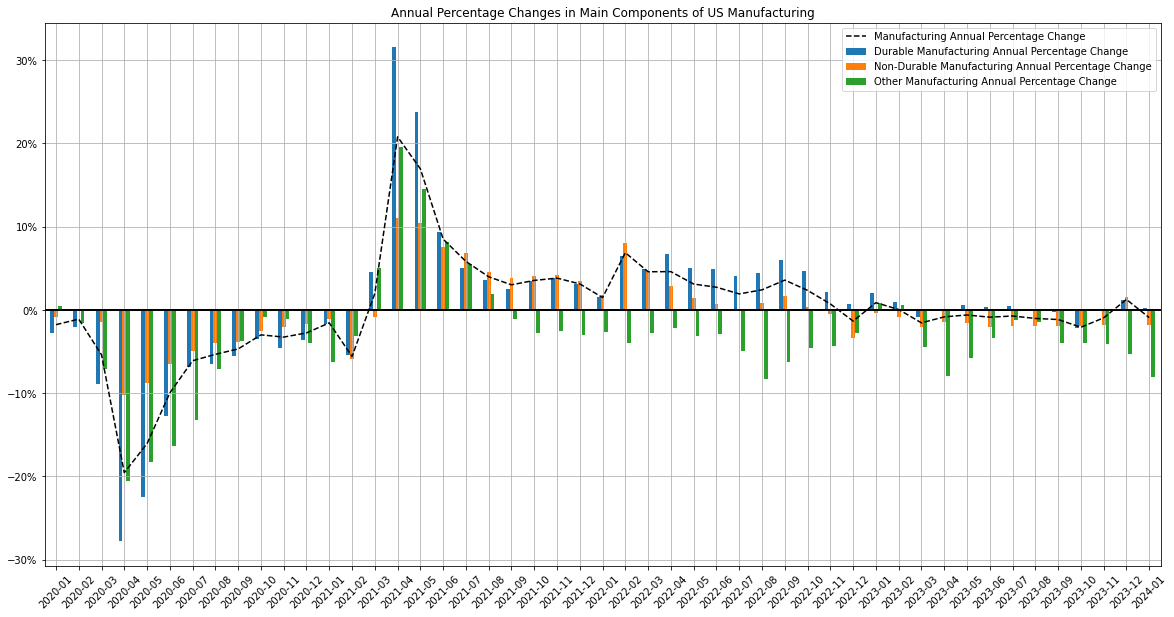

In [26]:
dt_from = date(2020, 1, 1)
ipman_components = ipman_components.loc[dt_from:]
ax = ipman_components.iloc[:,0].plot(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                                          xlabel='', rot=45, linestyle='--', color='k', use_index=False)
ipman_components.iloc[:,1:].plot.bar(ax=ax, grid=True, xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.axhline(y=0, lw=2, c='k')
ax.legend()
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipman_components.index)))

### Capacity Utilization in Manufacturing

In [27]:
indman_utilization = web.get_data_fred(['CAPUTLGMFDS', 'CAPUTLGMFNS', 'CAPUTLGMFOS'], start=report_start, end=report_end) / 100.
dt_from = date(2018, 1, 1)
indman_utilization = pd.concat([indpro_utilization.iloc[:, 1], indman_utilization.loc[dt_from:]], axis=1)

In [28]:
IPDMAN_CU_COLUMN_NAME = 'Durable Manufacturing Capacity Utilization'
IPNMAN_CU_COLUMN_NAME = 'Non-Durable Manufacturing Capacity Utilization'
IPGMFOS_CU_COLUMN_NAME = 'Other Manufacturing Annual Capacity Utilization'
GRAPH_TITLE_INDMAN_CU = 'Capacity Utilization in US Manufacturing'
indman_utilization.rename(
    columns={'CAPUTLGMFDS': IPDMAN_CU_COLUMN_NAME, 'CAPUTLGMFNS': IPNMAN_CU_COLUMN_NAME,
             'CAPUTLGMFOS': IPGMFOS_CU_COLUMN_NAME},
    inplace=True)

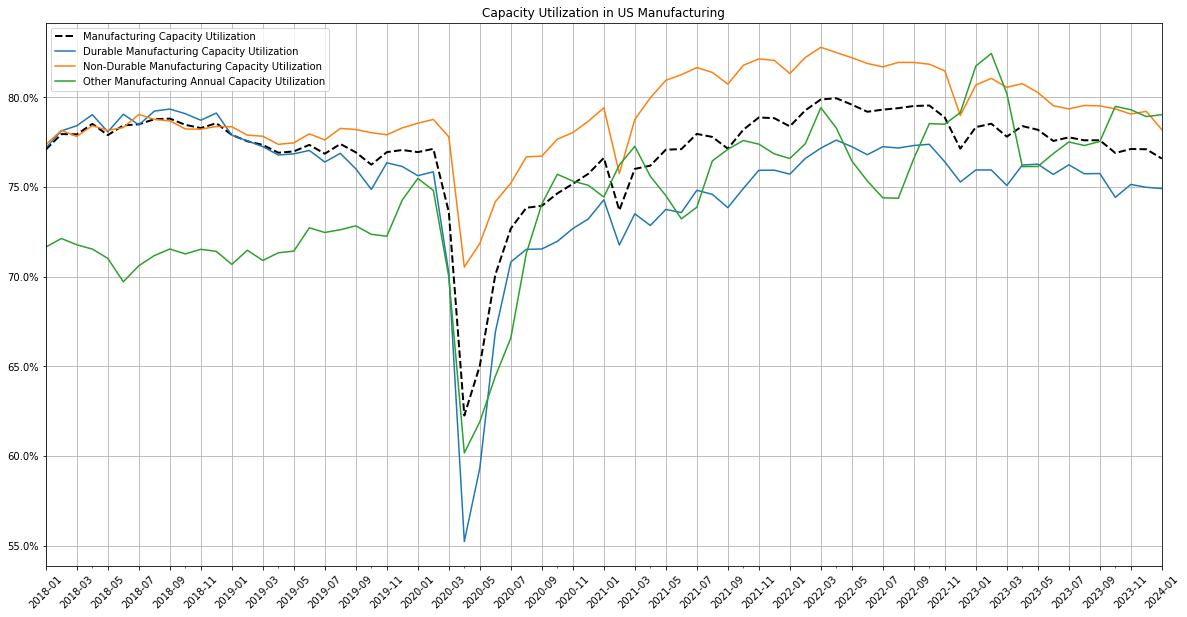

In [29]:
ax = indman_utilization.iloc[:,:1].plot(figsize=(20,10), grid=True,
             title=GRAPH_TITLE_INDMAN_CU,
             xticks=indman_utilization.index[::2], xlabel='', rot=45, linestyle='--', linewidth=2, color='k')
indman_utilization.iloc[:,1:].plot(ax=ax, grid=True, xticks=indman_utilization.index[::2], xlabel='', rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1.))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, indman_utilization.index[::2])))

## Zooming in on the Durable Manufacturing Industry Group

In [30]:
ipdman_components = web.get_data_fred(['IPG321S', 'IPG327S', 'IPG331S', 'IPG332S', 'IPG333S',
                                       'IPG334S', 'IPG335S', 'IPG3361T3S', 'IPG3364T9S',
                                       'IPG337S', 'IPG339S'], start=report_start, end=report_end)
# dt_from_ipdman = date(1970, 1, 1)
# ipdman_components = ipdman_components.loc[dt_from_ipdman:]

In [31]:
IPDMAN_WP_COLUMN_NAME = 'Wood Products'
IPDMAN_NMMP_COLUMN_NAME = 'Nonmetallic Mineral Product'
IPDMAN_PM_COLUMN_NAME = 'Primary Metals'
IPDMAN_FMP_COLUMN_NAME = 'Fabricated Metal Products'
IPDMAN_M_COLUMN_NAME = 'Machinery'
IPNMAN_CEP_COLUMN_NAME = 'Computer and Electronic Products'
IPDMAN_EE_COLUMN_NAME = 'Electrical Equipment'
IPDMAN_MVP_COLUMN_NAME = 'Motor Vehicles and Parts'
IPDMAN_AS_COLUMN_NAME = 'Aerospace'
IPDMAN_F_COLUMN_NAME = 'Furniture'
IPDMAN_MSC_COLUMN_NAME = 'Miscellaneous'
GRAPH_TITLE_IPDMAN_COMPONENTS = 'US Composition of Durable Manufacturing Industry Group'
GRAPH_TITLE_IPDMAN_COMPONENTS_PCT_CHG = 'Percentage Change in Output of Each Durable Manufacturing Industry Group'
ipdman_components.rename(
    columns={'IPG321S': IPDMAN_WP_COLUMN_NAME, 'IPG327S': IPDMAN_NMMP_COLUMN_NAME,
             'IPG331S': IPDMAN_PM_COLUMN_NAME, 'IPG332S': IPDMAN_FMP_COLUMN_NAME,
             'IPG333S': IPDMAN_M_COLUMN_NAME, 'IPG334S': IPNMAN_CEP_COLUMN_NAME,
             'IPG335S': IPDMAN_EE_COLUMN_NAME, 'IPG3361T3S': IPDMAN_MVP_COLUMN_NAME,
             'IPG3364T9S': IPDMAN_AS_COLUMN_NAME, 'IPG337S': IPDMAN_F_COLUMN_NAME,
             'IPG339S': IPDMAN_MSC_COLUMN_NAME},
    inplace=True)

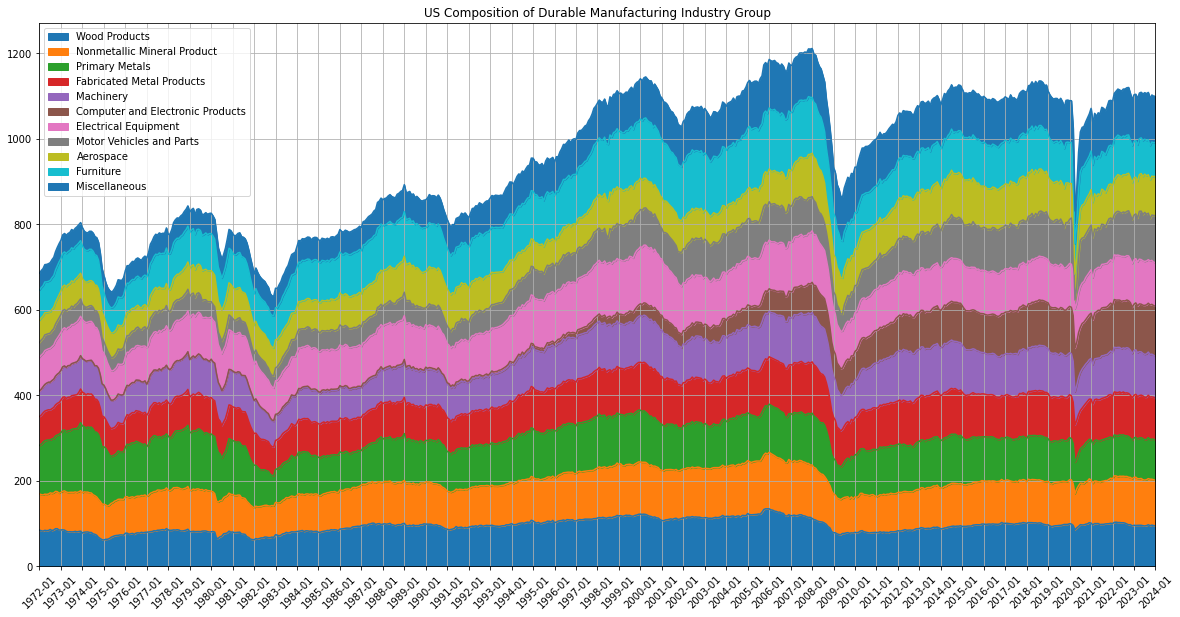

In [32]:
ax = ipdman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [33]:
# Converting to percentages by dividing by total
ipdman_components_pct = ipdman_components.divide(ipdman_components.sum(axis=1), axis=0)

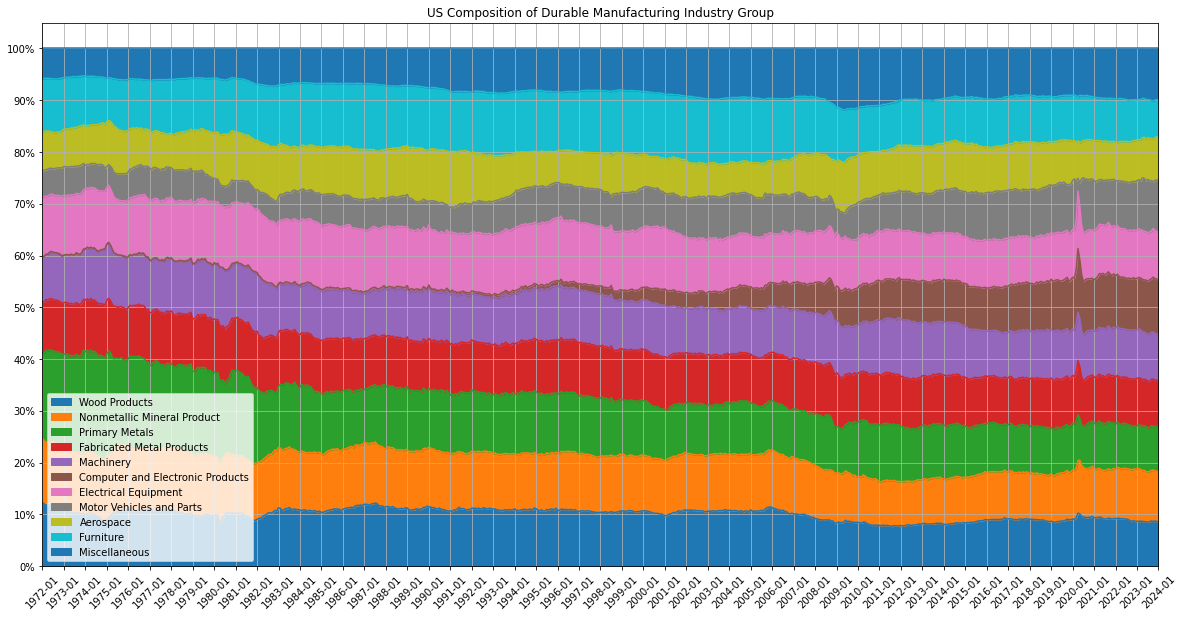

In [34]:
ax = ipdman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipdman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components_pct.index[::12])))

### Percentage Changes in Output of Each Durable Manufacturing Industry Group
To see which durable manufacturing industry groups have grown or shrunk over a given period of time, I carry out additional analysis below. I limit it to reviewing changes over the past 5 and 10 years. I compare output per industry group over the last 12 months with that 5 and 10 years ago. This is more accurate than comparing the output in a given month with that same month 5 and 10 years ago.

In [35]:
periods = [10, 5]
ipdman_components_pct_chg = pd.concat(
    [ipdman_components.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipdman_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

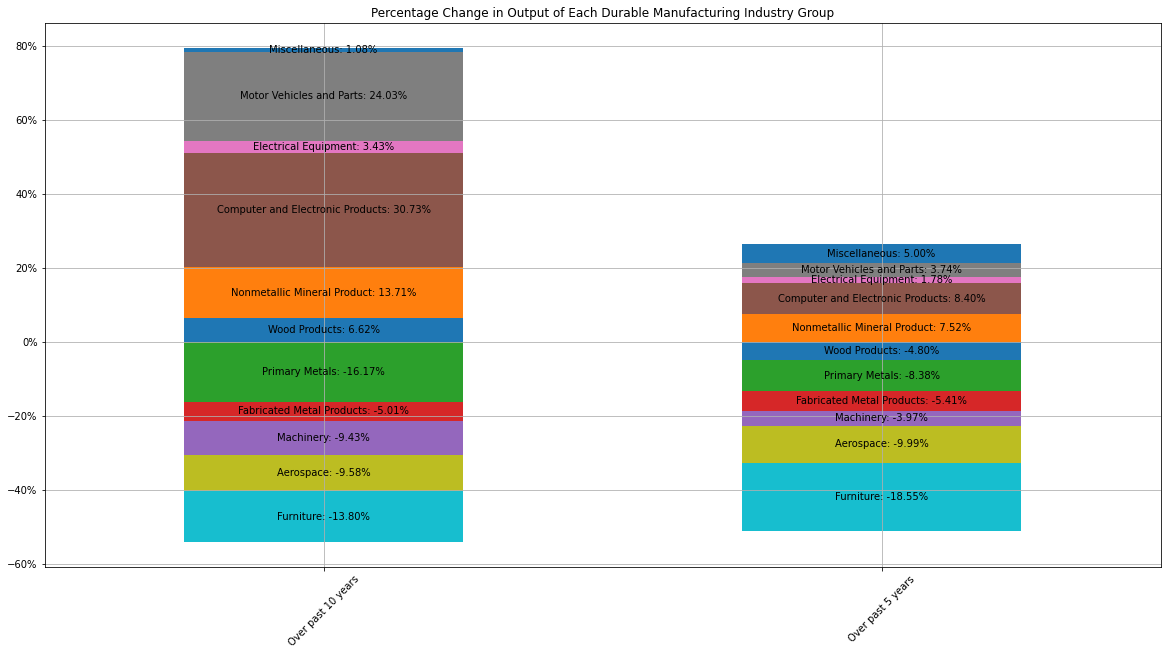

In [36]:
ax = ipdman_components_pct_chg.T.plot.bar(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS_PCT_CHG,
                                          stacked=True, rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

### Overall percentage changes in output of durable manufacturing

In [37]:
ipdman = web.get_data_fred('IPDMAN', start=report_start, end=report_end)
ipdman_pct_chg = pd.concat([ipdman.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods],
                           axis=1)
ipdman_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [38]:
ipdman_pct_chg

,Over past 10 years,Over past 5 years
IPDMAN,2.4196%,-1.8805%


## Zooming in on the Nondurable Manufacturing Industry Group

In [39]:
ipndman_components = web.get_data_fred(['IPG311A2S', 'IPG313A4S', 'IPG315A6S', 'IPG322S', 'IPG323S',
                                       'IPG324S', 'IPG325S', 'IPG326S'], start=report_start, end=report_end)

In [40]:
IPNDMAN_FBT_COLUMN_NAME = 'Food, Beverage, and Tobacco'
IPNDMAN_TP_COLUMN_NAME = 'Textiles and Products'
IPNDMAN_AL_COLUMN_NAME = 'Apparel and Leather Goods'
IPNDMAN_P_COLUMN_NAME = 'Paper'
IPNDMAN_PS_COLUMN_NAME = 'Printing and Related Support'
IPNDMAN_PCP_COLUMN_NAME = 'Petroleum and Coal Products'
IPNDMAN_C_COLUMN_NAME = 'Chemical'
IPNDMAN_PRP_COLUMN_NAME = 'Plastics and Rubber Products'
GRAPH_TITLE_IPNDMAN_COMPONENTS = 'US Composition of Nondurable Manufacturing Industry Group'
GRAPH_TITLE_IPNDMAN_COMPONENTS_PCT_CHG = 'Percentage Change in Output of Each Nondurable Manufacturing Industry Group'
ipndman_components.rename(
    columns={'IPG311A2S': IPNDMAN_FBT_COLUMN_NAME, 'IPG313A4S': IPNDMAN_TP_COLUMN_NAME,
             'IPG315A6S': IPNDMAN_AL_COLUMN_NAME, 'IPG322S': IPNDMAN_P_COLUMN_NAME,
             'IPG323S': IPNDMAN_PS_COLUMN_NAME, 'IPG324S': IPNDMAN_PCP_COLUMN_NAME,
             'IPG325S': IPNDMAN_C_COLUMN_NAME, 'IPG326S': IPNDMAN_PRP_COLUMN_NAME},
    inplace=True)

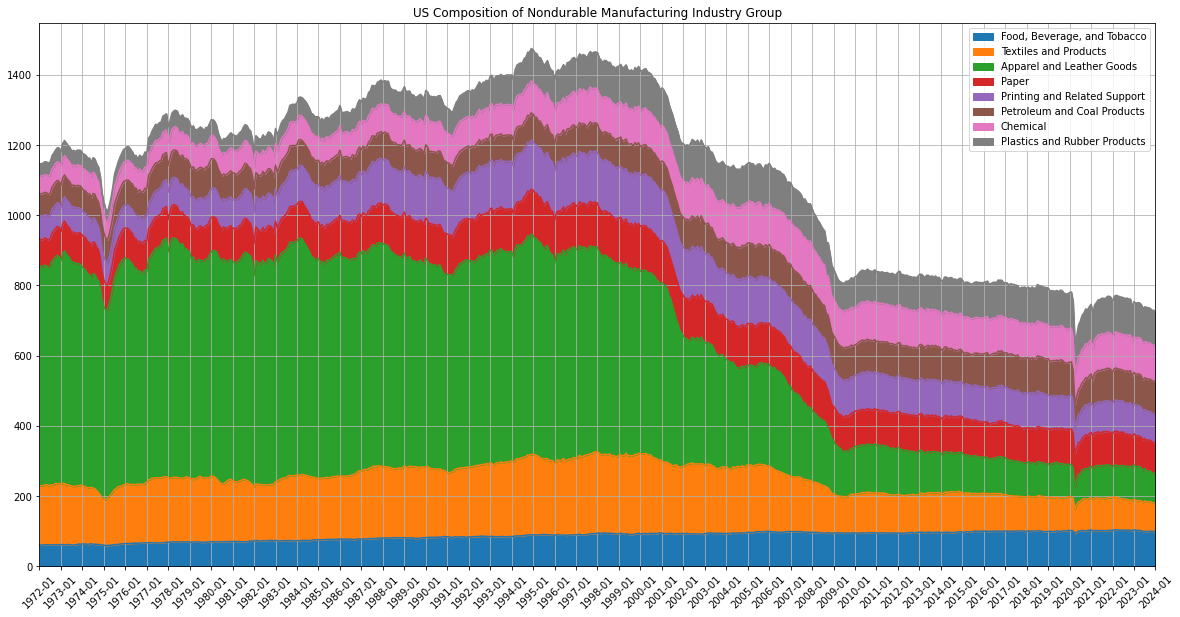

In [41]:
ax = ipndman_components.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPNDMAN_COMPONENTS,
                          xticks=ipdman_components.index[::12], xlabel='', rot=45)
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipdman_components.index[::12])))

In [42]:
# Converting to percentages by dividing by total
ipndman_components_pct = ipndman_components.divide(ipndman_components.sum(axis=1), axis=0)

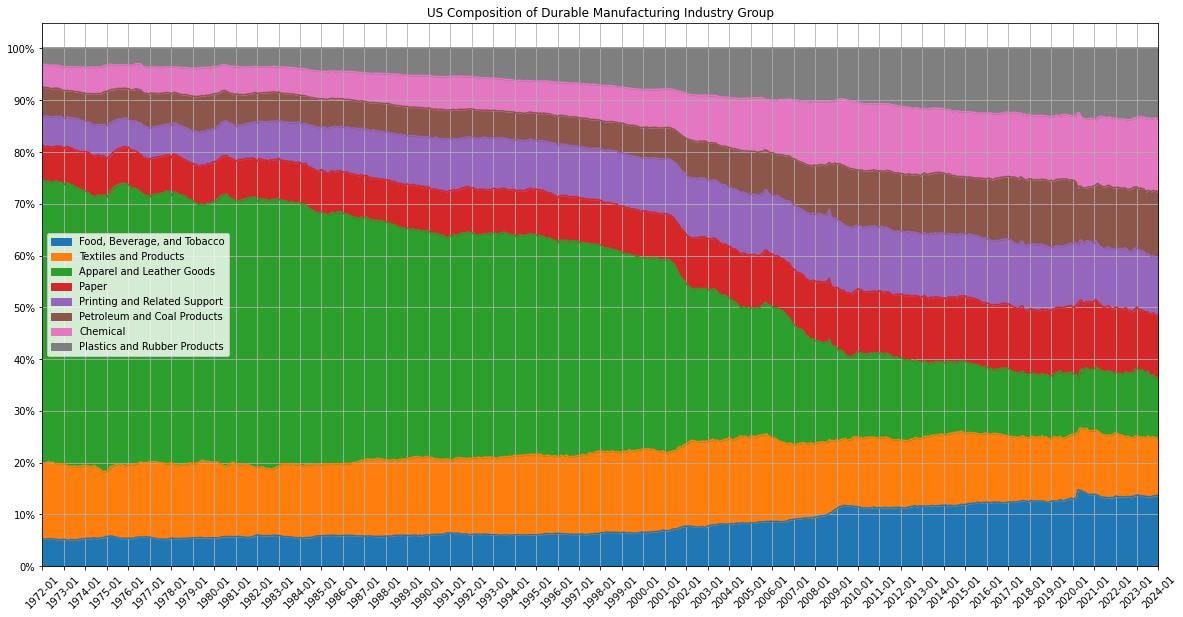

In [43]:
ax = ipndman_components_pct.plot.area(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPDMAN_COMPONENTS,
                              xticks=ipndman_components_pct.index[::12], xlabel='', rot=45,
                              yticks=np.arange(0, 1.01, .1))
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
_ = ax.set_xticklabels(list(map('{:%Y-%m}'.format, ipndman_components_pct.index[::12])))

### Percentage Changes in Output of Each Nondurable Manufacturing Industry Group
To see which nondurable manufacturing industry groups have grown or shrunk over a given period of time, I carry out additional analysis below. I limit it to reviewing changes over the past 5 and 10 years. I compare output per industry group over the last 12 months with that 5 and 10 years ago. This is more accurate than comparing the output in a given month with that same month 5 and 10 years ago.

In [44]:
ipndman_components_pct_chg = pd.concat(
    [ipndman_components.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipndman_components_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

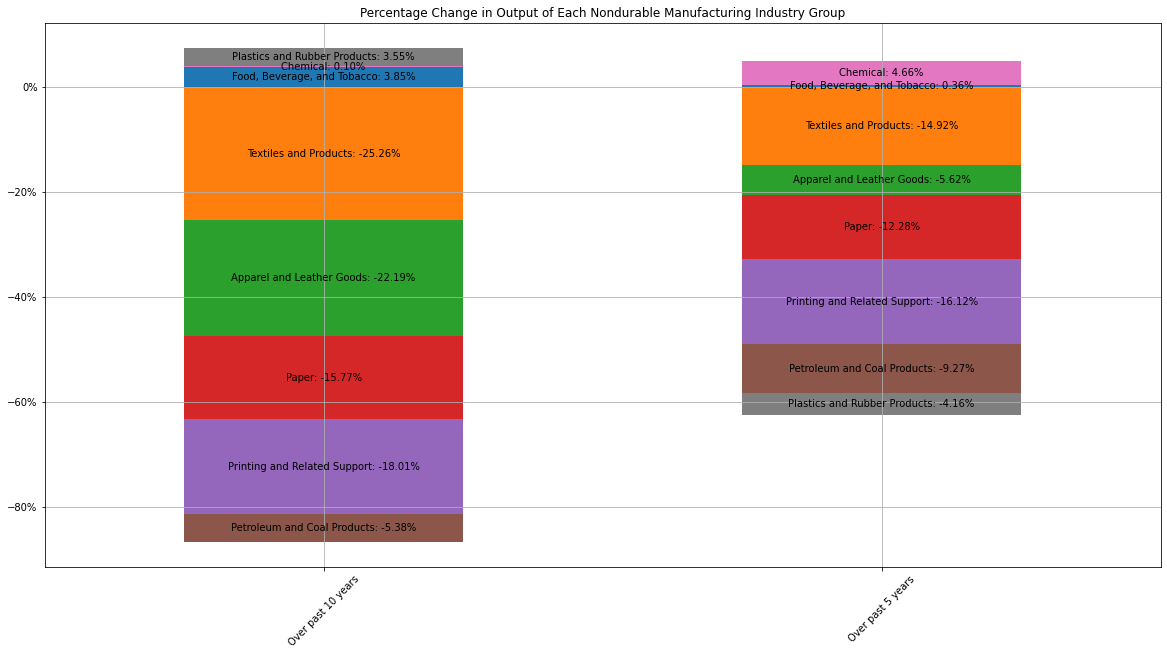

In [45]:
ax = ipndman_components_pct_chg.T.plot.bar(figsize=(20,10), grid=True, title=GRAPH_TITLE_IPNDMAN_COMPONENTS_PCT_CHG,
                                           stacked=True, rot=45)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(1))
ax.get_legend().remove()
for c in ax.containers:
    ax.bar_label(c, fmt=c.get_label() + ': {:.2%}', label_type='center')

### Overall percentache changes in output of nondurable manufacturing

In [46]:
ipnman = web.get_data_fred('IPNMAN', start=report_start, end=report_end)
ipnman_pct_chg = pd.concat([ipnman.rolling(12).sum().pct_change(12*period).iloc[-1] for period in periods], axis=1)
ipnman_pct_chg.columns = ['Over past {:d} years'.format(period) for period in periods]

In [47]:
ipnman_pct_chg

,Over past 10 years,Over past 5 years
IPNMAN,-1.2893%,-1.1804%
